In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置为支持中文的字体，如黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

图片 004A.png 和 004A1.png 的最佳旋转角度为: 18 度


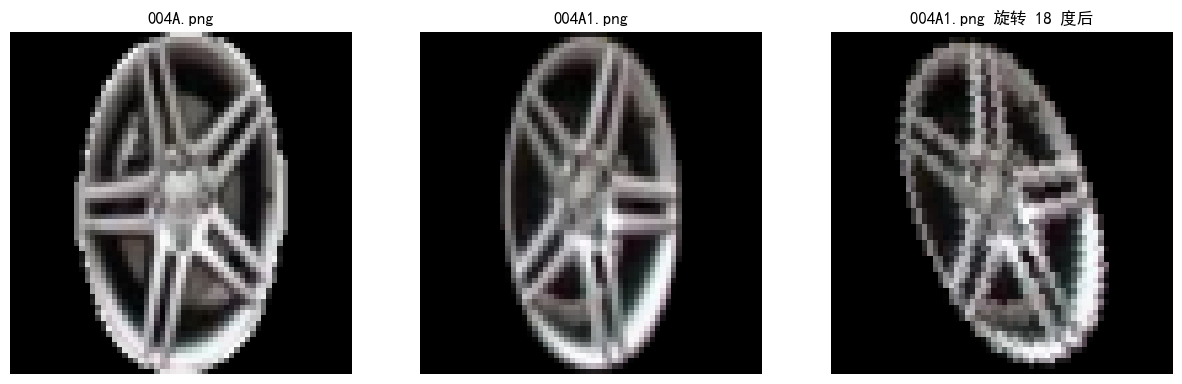

In [2]:
import numpy as np
from skimage.feature import local_binary_pattern
from skimage.transform import resize
from PIL import Image
import matplotlib.pyplot as plt

def convert_to_square(image, size=64):
    width, height = image.size
    if width == height:
        new_image = image
    elif width > height:
        new_image = Image.new("RGB", (width, width), (0, 0, 0))
        new_image.paste(image, (0, (width - height) // 2))
    else:
        new_image = Image.new("RGB", (height, height), (0, 0, 0))
        new_image.paste(image, ((height - width) // 2, 0))
    new_image = new_image.resize((size, size))
    return new_image

def extract_lbp_features(image, radius=3, n_points=8 * 3):
    all_hist = []
    for channel in range(image.shape[2]):
        channel_image = image[:, :, channel]
        lbp = local_binary_pattern(channel_image, n_points, radius, method='uniform')
        (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7)
        all_hist.extend(hist)
    return np.array(all_hist)

def cosine_similarity(feature1, feature2):
    dot_product = np.dot(feature1, feature2)
    norm_feature1 = np.linalg.norm(feature1)
    norm_feature2 = np.linalg.norm(feature2)
    similarity = dot_product / (norm_feature1 * norm_feature2)
    return similarity

def find_best_rotation_angle(image_path1, image_path2):
    image1 = Image.open(image_path1).convert('RGB')
    image2 = Image.open(image_path2).convert('RGB')

    square_image1 = convert_to_square(image1)
    square_image2 = convert_to_square(image2)

    base_image1 = np.array(square_image1)
    base_features1 = extract_lbp_features(base_image1)

    max_similarity = -1
    best_angle = 0
    best_rotated_image2 = None

    for angle in range(0, 72):
        rotated_image2 = square_image2.rotate(angle, center=(square_image2.width // 2, square_image2.height // 2))
        rotated_image2 = np.array(rotated_image2)

        features2 = extract_lbp_features(rotated_image2)
        similarity = cosine_similarity(base_features1, features2)

        if similarity > max_similarity:
            max_similarity = similarity
            best_angle = angle
            best_rotated_image2 = rotated_image2

    print(f"图片 {image_path1} 和 {image_path2} 的最佳旋转角度为: {best_angle} 度")

    # 显示图片
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(base_image1)
    axes[0].set_title(image_path1)
    axes[1].imshow(np.array(square_image2))
    axes[1].set_title(image_path2)
    axes[2].imshow(best_rotated_image2)
    axes[2].set_title(f"{image_path2} 旋转 {best_angle} 度后")

    for ax in axes:
        ax.axis('off')

    plt.show()

    return best_angle

# 输入图片路径
image_path1 = '004A.png'
image_path2 = '004A1.png'

# 找到最佳旋转角度
best_angle = find_best_rotation_angle(image_path1, image_path2)

In [3]:
from PIL import Image
import numpy as np

def convert_to_square(image, size=64):
    # 将图像转换为灰度图以便处理
    gray_image = image.convert('L')
    # 将图像转换为 numpy 数组
    img_array = np.array(gray_image)

    # 找到非零像素的坐标
    rows, cols = np.nonzero(img_array)
    if len(rows) == 0 or len(cols) == 0:
        return Image.new("RGB", (size, size), (0, 0, 0))

    # 计算椭圆的边界
    min_row, max_row = np.min(rows), np.max(rows)
    min_col, max_col = np.min(cols), np.max(cols)
    # 计算椭圆的长短轴长度
    major_axis = max(max_row - min_row, max_col - min_col)
    minor_axis = min(max_row - min_row, max_col - min_col)

    # 计算缩放比例
    scale_ratio = major_axis / minor_axis if minor_axis != 0 else 1

    # 根据长短轴方向进行缩放
    if max_row - min_row > max_col - min_col:
        new_width = int(image.width * scale_ratio)
        resized_image = image.resize((new_width, image.height))
    else:
        new_height = int(image.height * scale_ratio)
        resized_image = image.resize((image.width, new_height))

    # 重新计算灰度图和非零像素坐标
    gray_resized = resized_image.convert('L')
    resized_array = np.array(gray_resized)
    rows, cols = np.nonzero(resized_array)

    # 再次计算椭圆的边界
    min_row, max_row = np.min(rows), np.max(rows)
    min_col, max_col = np.min(cols), np.max(cols)

    # 裁剪出包含椭圆的正方形区域
    left = min_col
    top = min_row
    right = max_col
    bottom = max_row
    cropped_image = resized_image.crop((left, top, right, bottom))

    # 调整图像大小为指定尺寸
    final_image = cropped_image.resize((size, size))
    return final_image

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import cv2
import matplotlib
matplotlib.use('TkAgg')

import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置为支持中文的字体，如黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题



def convert_to_square(image, size=70):
    # 将图像转换为灰度图以便处理
    gray_image = image.convert('L')
    # 将图像转换为 numpy 数组
    img_array = np.array(gray_image)

    # 找到非零像素的坐标
    rows, cols = np.nonzero(img_array)
    if len(rows) == 0 or len(cols) == 0:
        return Image.new("RGB", (size, size), (0, 0, 0))

    # 计算椭圆的边界
    min_row, max_row = np.min(rows), np.max(rows)
    min_col, max_col = np.min(cols), np.max(cols)
    # 计算椭圆的长短轴长度
    major_axis = max(max_row - min_row, max_col - min_col)
    minor_axis = min(max_row - min_row, max_col - min_col)

    # 计算缩放比例
    scale_ratio = major_axis / minor_axis if minor_axis != 0 else 1

    # 根据长短轴方向进行缩放
    if max_row - min_row > max_col - min_col:
        new_width = int(image.width * scale_ratio)
        resized_image = image.resize((new_width, image.height))
    else:
        new_height = int(image.height * scale_ratio)
        resized_image = image.resize((image.width, new_height))

    # 重新计算灰度图和非零像素坐标
    gray_resized = resized_image.convert('L')
    resized_array = np.array(gray_resized)
    rows, cols = np.nonzero(resized_array)

    # 再次计算椭圆的边界
    min_row, max_row = np.min(rows), np.max(rows)
    min_col, max_col = np.min(cols), np.max(cols)

    # 裁剪出包含椭圆的正方形区域
    left = min_col
    top = min_row
    right = max_col
    bottom = max_row
    cropped_image = resized_image.crop((left, top, right, bottom))

    # 调整图像大小为指定尺寸
    final_image = cropped_image.resize((size, size))
    return final_image


def rotate_image_opencv(image, angle):
    # 将 PIL 图像转换为 OpenCV 格式
    img_array = np.array(image)
    height, width = img_array.shape[:2]
    # 计算旋转中心
    center = (width // 2, height // 2)
    # 获取旋转矩阵
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    # 进行旋转操作
    rotated_img_array = cv2.warpAffine(img_array, rotation_matrix, (width, height), borderMode=cv2.BORDER_REPLICATE)
    # 将 OpenCV 图像转换回 PIL 格式
    rotated_image = Image.fromarray(rotated_img_array)
    return rotated_image


def calculate_ssim(image1, image2):
    img1_array = np.array(image1.convert('L'))
    img2_array = np.array(image2.convert('L'))
    return ssim(img1_array, img2_array)


def find_best_rotation_angle(image_path1, image_path2):
    image1 = Image.open(image_path1).convert('RGB')
    image2 = Image.open(image_path2).convert('RGB')

    # 转换为正圆（内切于正方形）
    square_image1 = convert_to_square(image1)
    square_image2 = convert_to_square(image2)

    max_similarity = -1
    best_angle = 0
    best_rotated_image2 = None

    # 在 0 到 100 度范围内旋转
    for angle in range(1, 100):
        rotated_image2 = rotate_image_opencv(square_image2, angle)
        similarity = calculate_ssim(square_image1, rotated_image2)

        if similarity > max_similarity:
            max_similarity = similarity
            best_angle = angle
            best_rotated_image2 = rotated_image2

    print(f"图片 {image_path1} 和 {image_path2} 的最佳旋转角度为: {best_angle} 度")

    return square_image1, square_image2, best_rotated_image2, best_angle


def extract_sift_features(image):
    """
    提取图像的 SIFT 特征向量
    """
    img = np.array(image.convert('L'))
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    if des is None:
        return np.array([])
    return des


def cosine_similarity(feature1, feature2):
    """
    计算两个特征向量的余弦相似度
    """
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(feature1, feature2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    if len(good_matches) == 0:
        return 0

    matched_des1 = np.array([feature1[m.queryIdx] for m in good_matches])
    matched_des2 = np.array([feature2[m.trainIdx] for m in good_matches])

    dot_product = np.sum(matched_des1 * matched_des2, axis=1)
    norm_feature1 = np.linalg.norm(matched_des1, axis=1)
    norm_feature2 = np.linalg.norm(matched_des2, axis=1)

    similarities = dot_product / (norm_feature1 * norm_feature2)
    return np.mean(similarities)


def process_image_pair(image_path1, image_path2):
    # 找到最佳旋转角度并获取处理后的图片
    square_image1, square_image2, best_rotated_image2, best_angle = find_best_rotation_angle(image_path1, image_path2)

    # 提取 SIFT 特征
    feature1 = extract_sift_features(square_image1)
    feature2 = extract_sift_features(square_image2)
    feature2_rotated = extract_sift_features(best_rotated_image2)

    # 计算余弦相似度
    similarity_before_rotation = cosine_similarity(feature1, feature2)
    similarity_after_rotation = cosine_similarity(feature1, feature2_rotated)

    print(f"旋转前 {image_path1} 和 {image_path2} 的相似度: {similarity_before_rotation}")
    print(f"旋转 {best_angle} 度后 {image_path1} 和 {image_path2} 的相似度: {similarity_after_rotation}")

    # 显示图片
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(np.array(square_image1))
    axes[0].set_title(image_path1)
    axes[1].imshow(np.array(square_image2))
    axes[1].set_title(image_path2)
    axes[2].imshow(np.array(best_rotated_image2))
    axes[2].set_title(f"{image_path2} 旋转 {best_angle} 度后")

    for ax in axes:
        ax.axis('off')

    plt.show()


# 定义图片对列表
image_pairs = [
    ('006A.png', '006A1.png'),
    ('004A.png', '004A1.png'),
    ('005A.png', '005B.png'),
    ('006A.png', '004A1.png'),
    ('004A.png', '005A.png'),
    ('005A.png', '006A.png')
]

# 批量处理图片对
for image_path1, image_path2 in image_pairs:
    process_image_pair(image_path1, image_path2)

图片 006A.png 和 006A1.png 的最佳旋转角度为: 9 度
旋转前 006A.png 和 006A1.png 的相似度: 0.9176080822944641
旋转 9 度后 006A.png 和 006A1.png 的相似度: 0.9343878626823425
图片 004A.png 和 004A1.png 的最佳旋转角度为: 40 度
旋转前 004A.png 和 004A1.png 的相似度: 0.8893415927886963
旋转 40 度后 004A.png 和 004A1.png 的相似度: 0.8883563280105591
图片 005A.png 和 005B.png 的最佳旋转角度为: 12 度
旋转前 005A.png 和 005B.png 的相似度: 0.8879538178443909
旋转 12 度后 005A.png 和 005B.png 的相似度: 0.8655278086662292
图片 006A.png 和 004A1.png 的最佳旋转角度为: 95 度
旋转前 006A.png 和 004A1.png 的相似度: 0.9226878881454468
旋转 95 度后 006A.png 和 004A1.png 的相似度: 0
图片 004A.png 和 005A.png 的最佳旋转角度为: 97 度
旋转前 004A.png 和 005A.png 的相似度: 0.8586466312408447
旋转 97 度后 004A.png 和 005A.png 的相似度: 0.8485457301139832
图片 005A.png 和 006A.png 的最佳旋转角度为: 1 度
旋转前 005A.png 和 006A.png 的相似度: 0
旋转 1 度后 005A.png 和 006A.png 的相似度: 0
